# 3D-BPP

## Pre-requisites

In [1]:
import sys

sys.path.append("src/")

In [2]:
import os
from collections import namedtuple
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
from ortools.sat.python import cp_model
from matplotlib import pyplot as plt
from tqdm import tqdm


import config, dataset, main, utils, bins

In [3]:
%matplotlib notebook
%load_ext autoreload
%load_ext nb_black
%autoreload 2

<IPython.core.display.Javascript object>

In [4]:
plt.style.use("seaborn")
np.random.seed(config.RANDOM_SEED)

<IPython.core.display.Javascript object>

## Pallets and containers

Pallet EUR:

|       |  $L\times W\times H (cm)$   | Load (kg)  |
|:-----:|:--------------------------:|:--------:|
| EUR 1 |  $80\times 120\times 14.5$ |  $2490$  |
| EUR 2 | $120\times 100\times 14.4$ |  $1470$  |
| EUR 3 | $100\times 120\times 14.4$ |  $1920$  |
| EUR 6 |  $80\times 60\times 14.4$  |   $500$  |

Container ISO:

|   |  $L\times W\times H (cm)$  | Load (kg) |
|:-:|:--------------------------:|:--------:|
| 1A | $233\times 1200\times 220$ |  $26480$ |
| 1C |  $233\times 587\times 220$ |  $28180$ |

## Dataset

### Products

In [5]:
product_dataset = dataset.ProductDataset(
    "data/products.pkl",
    config.NUM_PRODUCTS,
    config.MIN_PRODUCT_WIDTH,
    config.MAX_PRODUCT_WIDTH,
    config.MIN_PRODUCT_DEPTH,
    config.MAX_PRODUCT_DEPTH,
    config.MIN_PRODUCT_HEIGHT,
    config.MAX_PRODUCT_HEIGHT,
    config.MIN_PRODUCT_WEIGHT,
    config.MAX_PRODUCT_WEIGHT,
    force_overload=False,
)
product_dataset.products.head()

,width,depth,height,weight,volume
0,160,280,233,8,10438400
1,199,269,260,11,13918060
2,187,101,283,2,5345021
3,126,149,214,2,4017636
4,248,132,280,3,9166080


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


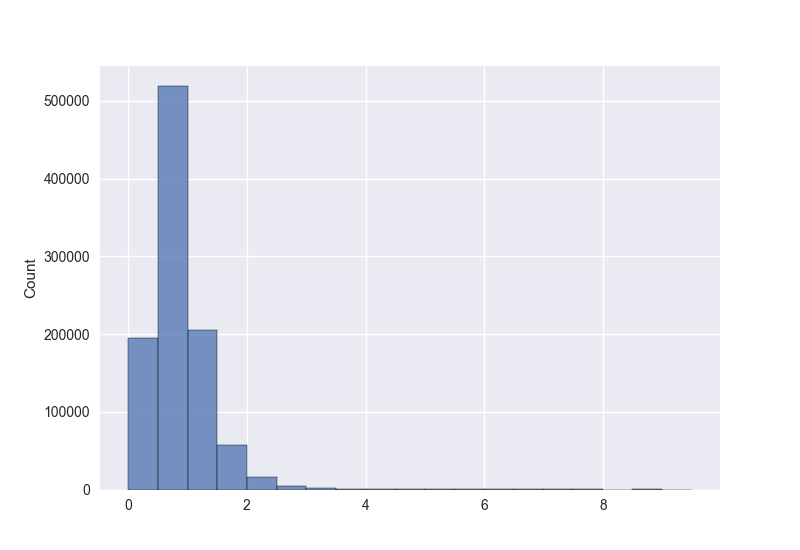

<IPython.core.display.Javascript object>

In [125]:
plt.figure()
sns.histplot(
    product_dataset.products.depth / product_dataset.products.width,
    bins=np.arange(0, 10, 0.5),
)
plt.show()

<IPython.core.display.Javascript object>


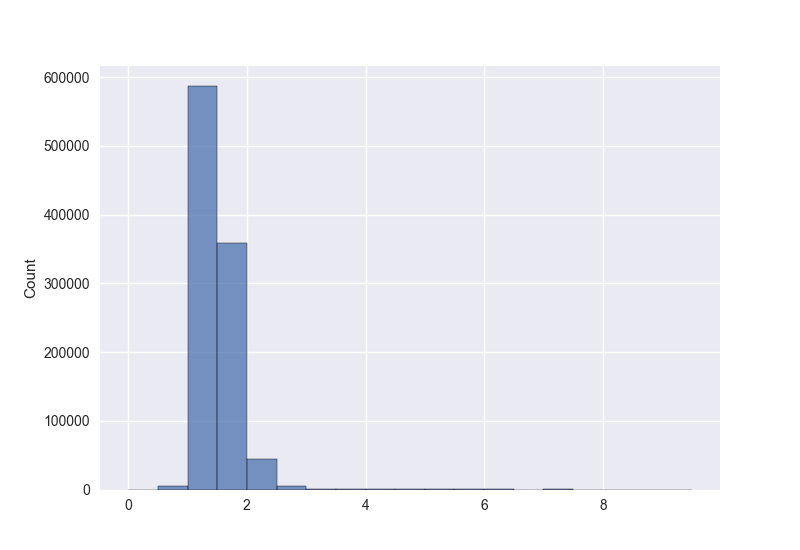

<IPython.core.display.Javascript object>

In [126]:
plt.figure()
sns.histplot(
    product_dataset.products.height / product_dataset.products.width,
    bins=np.arange(0, 10, 0.5),
)
plt.show()

<IPython.core.display.Javascript object>


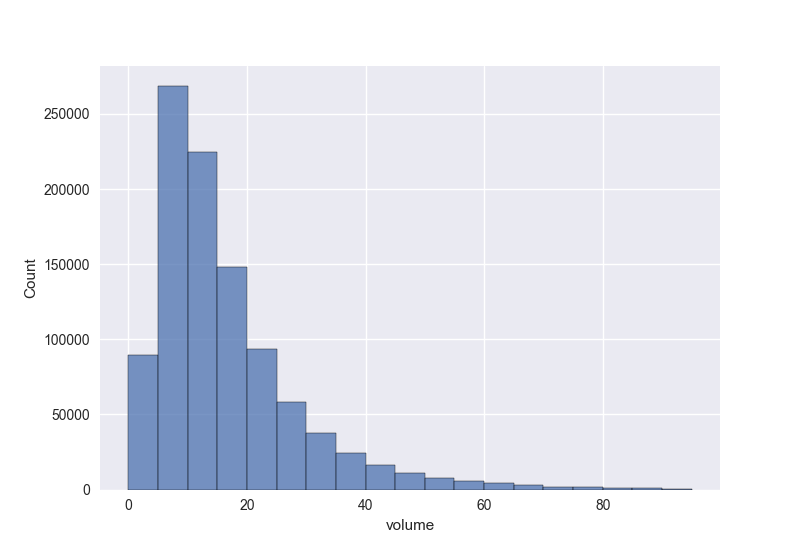

<IPython.core.display.Javascript object>

In [127]:
plt.figure()
sns.histplot(product_dataset.products.volume / 1e6, bins=np.arange(0, 100, 5))
plt.show()

<IPython.core.display.Javascript object>


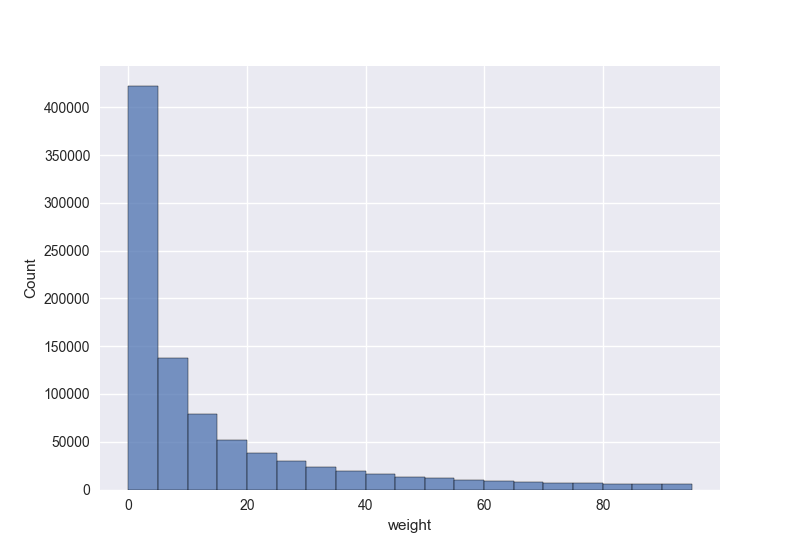

<IPython.core.display.Javascript object>

In [128]:
plt.figure()
sns.histplot(product_dataset.products.weight, bins=np.arange(0, 100, 5))
plt.show()

<IPython.core.display.Javascript object>


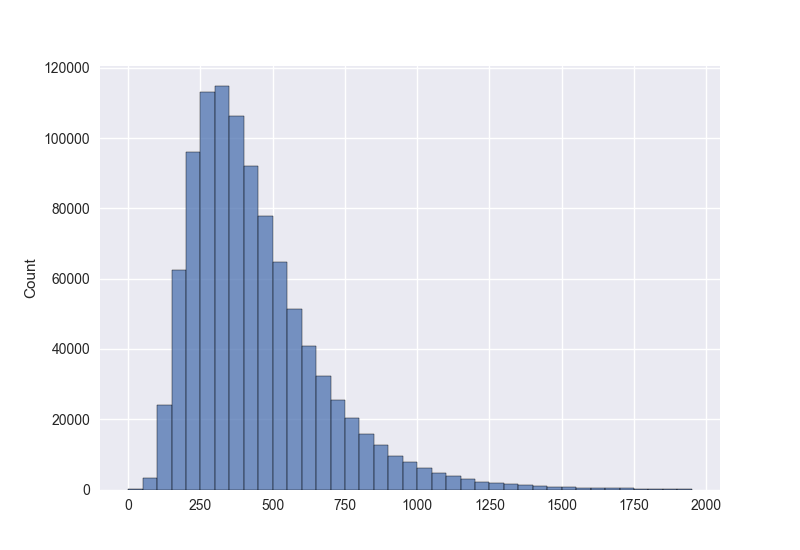

<IPython.core.display.Javascript object>

In [129]:
plt.figure()
sns.histplot(
    product_dataset.products.width * product_dataset.products.depth / 100,
    bins=np.arange(0, 2000, 50),
)
plt.show()

### Order

In [6]:
ordered_products = 50
order = product_dataset.get_order(ordered_products)
# order = product_dataset.get_dummy_order(ordered_products)
order.head()

,id,width,depth,height,weight,volume
0,121958,193,221,371,2,15824263
1,671155,236,142,437,58,14644744
2,131932,228,139,254,26,8049768
3,365838,267,131,322,11,11262594
4,259178,253,191,580,68,28027340


<IPython.core.display.Javascript object>

## Martello's lower bounds

In [131]:
utils.get_l0_lb(order, config.PALLET_DIMS)

1.0

<IPython.core.display.Javascript object>

In [132]:
utils.get_l1_lb(order, config.PALLET_DIMS)

(0.0, 0.0, 0.0, 0.0)

<IPython.core.display.Javascript object>

In [70]:
utils.get_l2_lb(order, config.PALLET_DIMS)

2500it [00:10, 231.49it/s]
2450it [00:10, 233.15it/s]
2450it [00:10, 234.02it/s]


(1.0, 1.0, 1.0, 1.0)

<IPython.core.display.Javascript object>

## Baseline

In [133]:
bl_order = product_dataset.get_order(20)

<IPython.core.display.Javascript object>

In [138]:
bl_bin_pool = main.main(bl_order, procedure="bl", tlim=20)
bl_bin_pool.get_original_layer_pool().to_dataframe()

2021-08-14 14:45:07.238 | INFO     | main:main:166 - BL procedure starting
2021-08-14 14:45:07.239 | INFO     | main:main:176 - BL iteration 1/1
2021-08-14 14:45:07.242 | DEBUG    | superitems:_gen_single_items_superitems:634 - Generated 20 superitems with a single item
2021-08-14 14:45:07.243 | INFO     | superitems:gen_superitems:618 - Generating horizontal superitems of type 'two-width'
2021-08-14 14:45:07.243 | DEBUG    | superitems:_gen_superitems_horizontal:680 - Generated 0 horizontal superitems with 2 items
2021-08-14 14:45:07.244 | DEBUG    | superitems:_gen_superitems_horizontal:687 - Generated 0 horizontal superitems with 4 items
2021-08-14 14:45:07.244 | INFO     | superitems:gen_superitems:621 - Generating vertical superitems with maximum stacking of 4
2021-08-14 14:45:07.245 | DEBUG    | superitems:_gen_superitems_vertical:765 - Generated 15 wide vertical superitems
2021-08-14 14:45:07.246 | DEBUG    | superitems:_gen_superitems_vertical:767 - Generated 1 deep vertical su

,item,x,y,z,width,depth,height,layer
0,0,481,602,0,213,188,313,0
1,1,532,1,0,300,291,444,0
2,2,704,668,0,317,110,484,0
3,3,245,1,0,287,157,333,0
4,5,1021,602,0,177,174,226,0
5,6,849,0,0,350,287,441,0
6,7,242,397,0,219,205,393,0
7,8,365,302,0,339,84,417,0
8,9,570,443,0,123,159,227,0
9,11,242,602,0,239,159,354,0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


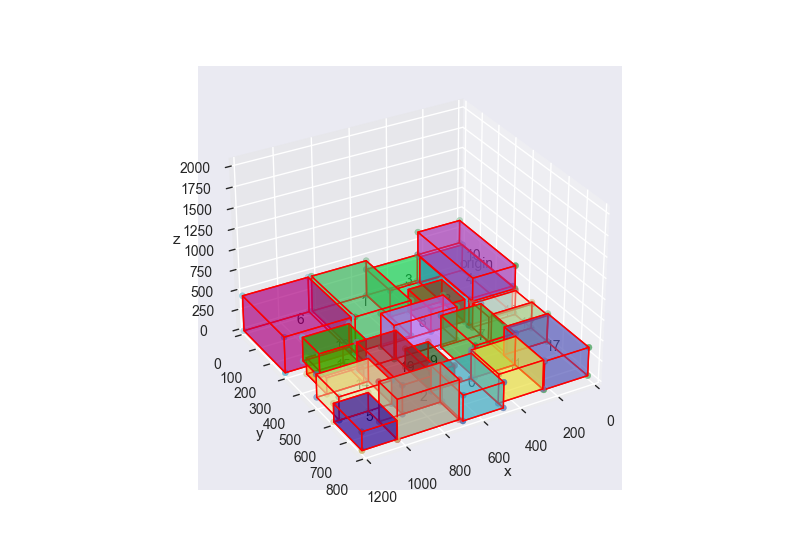

[<Axes3DSubplot:xlabel='x', ylabel='y'>]

<IPython.core.display.Javascript object>

In [139]:
bl_bin_pool.get_original_bin_pool().plot()

<IPython.core.display.Javascript object>


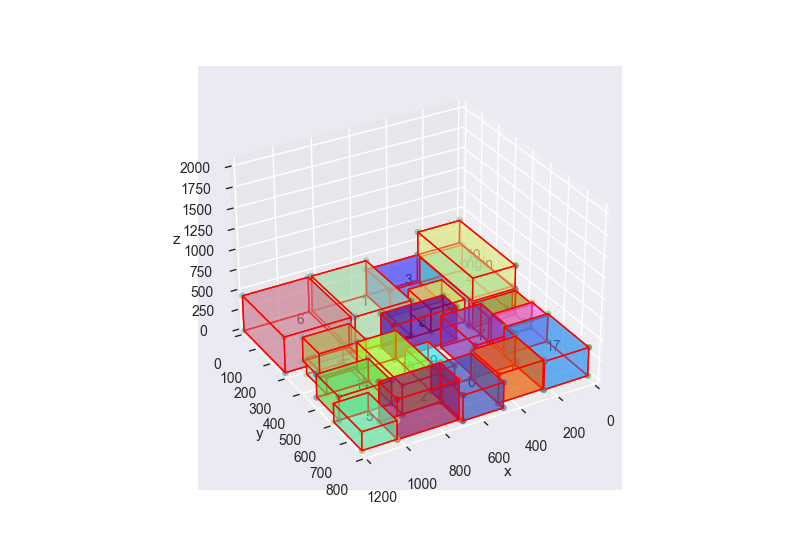

[<Axes3DSubplot:xlabel='x', ylabel='y'>]

<IPython.core.display.Javascript object>

In [140]:
bl_bin_pool.plot()

## Maxrects

In [15]:
mr_bin_pool = main.main(
    order,
    procedure="mr",
    superitems_horizontal=True,
    superitems_horizontal_type="two-width",
)
mr_bin_pool.get_original_layer_pool().to_dataframe()

2021-08-14 14:54:52.707 | INFO     | main:main:166 - MR procedure starting
2021-08-14 14:54:52.708 | INFO     | main:main:176 - MR iteration 1/1
2021-08-14 14:54:52.714 | DEBUG    | superitems:_gen_single_items_superitems:634 - Generated 50 superitems with a single item
2021-08-14 14:54:52.715 | INFO     | superitems:gen_superitems:618 - Generating horizontal superitems of type 'two-width'
2021-08-14 14:54:52.715 | DEBUG    | superitems:_gen_superitems_horizontal:680 - Generated 0 horizontal superitems with 2 items
2021-08-14 14:54:52.716 | DEBUG    | superitems:_gen_superitems_horizontal:687 - Generated 0 horizontal superitems with 4 items
2021-08-14 14:54:52.717 | INFO     | superitems:gen_superitems:621 - Generating vertical superitems with maximum stacking of 4
2021-08-14 14:54:52.718 | DEBUG    | superitems:_gen_superitems_vertical:765 - Generated 34 wide vertical superitems
2021-08-14 14:54:52.719 | DEBUG    | superitems:_gen_superitems_vertical:767 - Generated 14 deep vertical s

,item,x,y,z,width,depth,height,layer
0,0,0,0,0,193,221,371,0
1,1,193,0,0,236,142,437,0
2,2,429,0,0,228,139,254,0
3,3,657,0,0,267,131,322,0
4,4,924,0,0,253,191,580,0
5,5,429,139,0,286,158,481,0
6,6,715,191,0,318,267,483,0
7,7,0,221,0,245,379,394,0
8,8,245,297,0,249,142,388,0
9,9,1033,191,0,143,343,297,0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


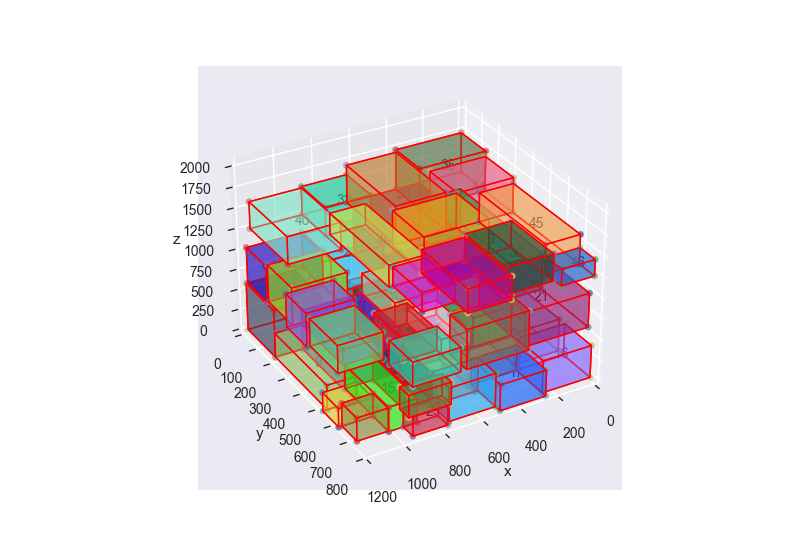

[<Axes3DSubplot:xlabel='x', ylabel='y'>]

<IPython.core.display.Javascript object>

In [16]:
mr_bin_pool.get_original_bin_pool().plot()

<IPython.core.display.Javascript object>


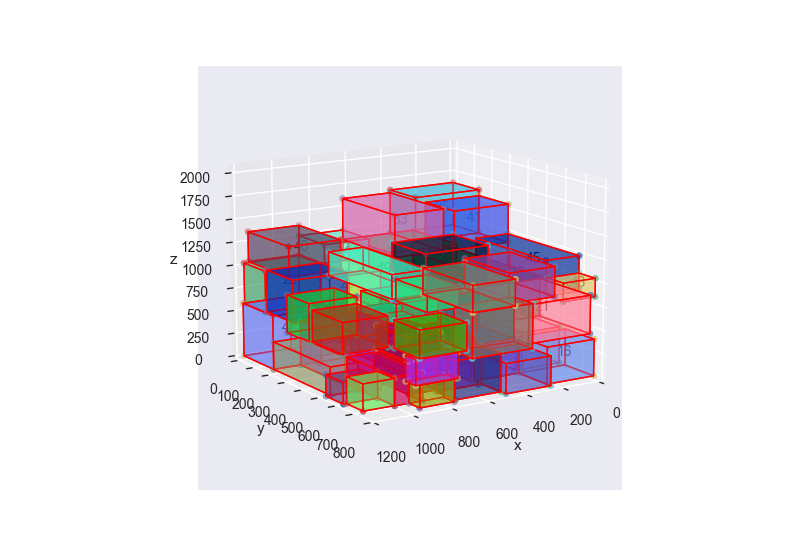

[<Axes3DSubplot:xlabel='x', ylabel='y'>]

<IPython.core.display.Javascript object>

In [17]:
mr_bin_pool.plot()

## Column generation

In [30]:
cg_bin_pool = main.main(
    order,
    procedure="cg",
    max_iters=1,
    superitems_horizontal=True,
    superitems_horizontal_type="two-width",
    tlim=5,
    use_height_groups=False,
    mr_warm_start=False,
    cg_max_iters=20,
    cg_max_stag_iters=3,
    cg_sp_mr=False,
    cg_sp_np_type="mip",
    cg_sp_p_type="cp",
    cg_return_only_last=False,
)
cg_bin_pool.get_original_layer_pool().to_dataframe()

2021-08-14 15:02:35.148 | INFO     | main:main:166 - CG procedure starting
2021-08-14 15:02:35.148 | INFO     | main:main:176 - CG iteration 1/1
2021-08-14 15:02:35.155 | DEBUG    | superitems:_gen_single_items_superitems:634 - Generated 50 superitems with a single item
2021-08-14 15:02:35.155 | INFO     | superitems:gen_superitems:618 - Generating horizontal superitems of type 'two-width'
2021-08-14 15:02:35.156 | DEBUG    | superitems:_gen_superitems_horizontal:680 - Generated 0 horizontal superitems with 2 items
2021-08-14 15:02:35.157 | DEBUG    | superitems:_gen_superitems_horizontal:687 - Generated 0 horizontal superitems with 4 items
2021-08-14 15:02:35.157 | INFO     | superitems:gen_superitems:621 - Generating vertical superitems with maximum stacking of 4
2021-08-14 15:02:35.158 | DEBUG    | superitems:_gen_superitems_vertical:765 - Generated 34 wide vertical superitems
2021-08-14 15:02:35.159 | DEBUG    | superitems:_gen_superitems_vertical:767 - Generated 14 deep vertical s

2021-08-14 15:02:50.419 | WARNING  | column_generation:pricing_problem_placement_cp:444 - SP-P-CP unfeasible
2021-08-14 15:02:50.419 | DEBUG    | column_generation:pricing_problem_placement_cp:446 - SP-P-CP time: 5.008493759
2021-08-14 15:02:50.420 | INFO     | column_generation:pricing_problem_no_placement_mip:179 - SP-NP-MIP defining variables and constraints
2021-08-14 15:02:50.426 | INFO     | column_generation:pricing_problem_no_placement_mip:216 - SP-NP-MIP feasibility: max number of selected items <= 21
2021-08-14 15:02:50.426 | DEBUG    | column_generation:pricing_problem_no_placement_mip:224 - SP-NP-MIP zero duals reward: 0.0005260389268805891
2021-08-14 15:02:50.427 | DEBUG    | column_generation:pricing_problem_no_placement_mip:239 - SP-NP-MIP variables: 99
2021-08-14 15:02:50.427 | DEBUG    | column_generation:pricing_problem_no_placement_mip:240 - SP-NP-MIP constraints: 100
2021-08-14 15:02:50.432 | DEBUG    | column_generation:pricing_problem_no_placement_mip:242 - SP-NP-

2021-08-14 15:03:10.600 | DEBUG    | column_generation:pricing_problem_no_placement_mip:251 - SP-NP-MIP objective: -22226.0
2021-08-14 15:03:10.600 | DEBUG    | column_generation:pricing_problem_no_placement_mip:254 - SP-NP-MIP selected 17/98 superitems
2021-08-14 15:03:10.601 | DEBUG    | column_generation:pricing_problem_no_placement_mip:256 - SP-NP-MIP computed layer height: -0.0
2021-08-14 15:03:10.601 | DEBUG    | column_generation:pricing_problem_no_placement_mip:260 - SP-NP-MIP time: 0.014
2021-08-14 15:03:10.608 | INFO     | column_generation:pricing_problem_placement_cp:361 - SP-P-CP defining variables and constraints
2021-08-14 15:03:15.624 | WARNING  | column_generation:pricing_problem_placement_cp:444 - SP-P-CP unfeasible
2021-08-14 15:03:15.625 | DEBUG    | column_generation:pricing_problem_placement_cp:446 - SP-P-CP time: 5.011461461000001
2021-08-14 15:03:15.625 | INFO     | column_generation:pricing_problem_no_placement_mip:179 - SP-NP-MIP defining variables and constra

2021-08-14 15:03:35.797 | DEBUG    | column_generation:pricing_problem_no_placement_mip:224 - SP-NP-MIP zero duals reward: 0.0005260389268805891
2021-08-14 15:03:35.797 | DEBUG    | column_generation:pricing_problem_no_placement_mip:239 - SP-NP-MIP variables: 99
2021-08-14 15:03:35.798 | DEBUG    | column_generation:pricing_problem_no_placement_mip:240 - SP-NP-MIP constraints: 100
2021-08-14 15:03:35.801 | DEBUG    | column_generation:pricing_problem_no_placement_mip:242 - SP-NP-MIP iterations: 4
2021-08-14 15:03:35.802 | INFO     | column_generation:pricing_problem_no_placement_mip:248 - SP-NP-MIP solved
2021-08-14 15:03:35.803 | DEBUG    | column_generation:pricing_problem_no_placement_mip:251 - SP-NP-MIP objective: -17190.0
2021-08-14 15:03:35.803 | DEBUG    | column_generation:pricing_problem_no_placement_mip:254 - SP-NP-MIP selected 12/98 superitems
2021-08-14 15:03:35.804 | DEBUG    | column_generation:pricing_problem_no_placement_mip:256 - SP-NP-MIP computed layer height: -0.0
2

2021-08-14 15:03:51.100 | WARNING  | column_generation:pricing_problem_placement_cp:444 - SP-P-CP unfeasible
2021-08-14 15:03:51.101 | DEBUG    | column_generation:pricing_problem_placement_cp:446 - SP-P-CP time: 5.009717342
2021-08-14 15:03:51.102 | INFO     | column_generation:pricing_problem_no_placement_mip:179 - SP-NP-MIP defining variables and constraints
2021-08-14 15:03:51.109 | INFO     | column_generation:pricing_problem_no_placement_mip:216 - SP-NP-MIP feasibility: max number of selected items <= 25
2021-08-14 15:03:51.110 | DEBUG    | column_generation:pricing_problem_no_placement_mip:224 - SP-NP-MIP zero duals reward: 0.0009354536950420954
2021-08-14 15:03:51.110 | DEBUG    | column_generation:pricing_problem_no_placement_mip:239 - SP-NP-MIP variables: 99
2021-08-14 15:03:51.111 | DEBUG    | column_generation:pricing_problem_no_placement_mip:240 - SP-NP-MIP constraints: 100
2021-08-14 15:03:51.128 | DEBUG    | column_generation:pricing_problem_no_placement_mip:242 - SP-NP-

2021-08-14 15:04:11.363 | DEBUG    | column_generation:pricing_problem_no_placement_mip:251 - SP-NP-MIP objective: -12750.0
2021-08-14 15:04:11.364 | DEBUG    | column_generation:pricing_problem_no_placement_mip:254 - SP-NP-MIP selected 21/98 superitems
2021-08-14 15:04:11.364 | DEBUG    | column_generation:pricing_problem_no_placement_mip:256 - SP-NP-MIP computed layer height: -0.0
2021-08-14 15:04:11.365 | DEBUG    | column_generation:pricing_problem_no_placement_mip:260 - SP-NP-MIP time: 0.019
2021-08-14 15:04:11.372 | INFO     | column_generation:pricing_problem_placement_cp:361 - SP-P-CP defining variables and constraints
2021-08-14 15:04:16.388 | WARNING  | column_generation:pricing_problem_placement_cp:444 - SP-P-CP unfeasible
2021-08-14 15:04:16.388 | DEBUG    | column_generation:pricing_problem_placement_cp:446 - SP-P-CP time: 5.010940899
2021-08-14 15:04:16.389 | INFO     | column_generation:pricing_problem_no_placement_mip:179 - SP-NP-MIP defining variables and constraints
2

2021-08-14 15:04:36.559 | DEBUG    | column_generation:pricing_problem_no_placement_mip:224 - SP-NP-MIP zero duals reward: 0.0009354536950420954
2021-08-14 15:04:36.560 | DEBUG    | column_generation:pricing_problem_no_placement_mip:239 - SP-NP-MIP variables: 99
2021-08-14 15:04:36.561 | DEBUG    | column_generation:pricing_problem_no_placement_mip:240 - SP-NP-MIP constraints: 100
2021-08-14 15:04:36.564 | DEBUG    | column_generation:pricing_problem_no_placement_mip:242 - SP-NP-MIP iterations: 4
2021-08-14 15:04:36.565 | INFO     | column_generation:pricing_problem_no_placement_mip:248 - SP-NP-MIP solved
2021-08-14 15:04:36.566 | DEBUG    | column_generation:pricing_problem_no_placement_mip:251 - SP-NP-MIP objective: -11044.000000000002
2021-08-14 15:04:36.566 | DEBUG    | column_generation:pricing_problem_no_placement_mip:254 - SP-NP-MIP selected 16/98 superitems
2021-08-14 15:04:36.567 | DEBUG    | column_generation:pricing_problem_no_placement_mip:256 - SP-NP-MIP computed layer hei

2021-08-14 15:04:46.798 | DEBUG    | column_generation:pricing_problem_no_placement_mip:260 - SP-NP-MIP time: 0.018
2021-08-14 15:04:46.805 | INFO     | column_generation:pricing_problem_placement_cp:361 - SP-P-CP defining variables and constraints
2021-08-14 15:04:51.820 | WARNING  | column_generation:pricing_problem_placement_cp:444 - SP-P-CP unfeasible
2021-08-14 15:04:51.820 | DEBUG    | column_generation:pricing_problem_placement_cp:446 - SP-P-CP time: 5.009130610000001
2021-08-14 15:04:51.821 | INFO     | column_generation:pricing_problem_no_placement_mip:179 - SP-NP-MIP defining variables and constraints
2021-08-14 15:04:51.827 | INFO     | column_generation:pricing_problem_no_placement_mip:216 - SP-NP-MIP feasibility: max number of selected items <= 16
2021-08-14 15:04:51.828 | DEBUG    | column_generation:pricing_problem_no_placement_mip:224 - SP-NP-MIP zero duals reward: 0.0010834236186348866
2021-08-14 15:04:51.829 | DEBUG    | column_generation:pricing_problem_no_placement_

2021-08-14 15:05:11.982 | DEBUG    | column_generation:pricing_problem_no_placement_mip:242 - SP-NP-MIP iterations: 4
2021-08-14 15:05:11.983 | INFO     | column_generation:pricing_problem_no_placement_mip:248 - SP-NP-MIP solved
2021-08-14 15:05:11.984 | DEBUG    | column_generation:pricing_problem_no_placement_mip:251 - SP-NP-MIP objective: -6428.000000000004
2021-08-14 15:05:11.984 | DEBUG    | column_generation:pricing_problem_no_placement_mip:254 - SP-NP-MIP selected 12/98 superitems
2021-08-14 15:05:11.985 | DEBUG    | column_generation:pricing_problem_no_placement_mip:256 - SP-NP-MIP computed layer height: -0.0
2021-08-14 15:05:11.985 | DEBUG    | column_generation:pricing_problem_no_placement_mip:260 - SP-NP-MIP time: 0.014
2021-08-14 15:05:11.993 | INFO     | column_generation:pricing_problem_placement_cp:361 - SP-P-CP defining variables and constraints
2021-08-14 15:05:12.660 | INFO     | column_generation:pricing_problem_placement_cp:430 - SP-P-CP solved
2021-08-14 15:05:12.6

2021-08-14 15:05:27.866 | DEBUG    | column_generation:pricing_problem_placement_cp:446 - SP-P-CP time: 5.0107795280000005
2021-08-14 15:05:27.867 | INFO     | column_generation:pricing_problem_no_placement_mip:179 - SP-NP-MIP defining variables and constraints
2021-08-14 15:05:27.874 | INFO     | column_generation:pricing_problem_no_placement_mip:216 - SP-NP-MIP feasibility: max number of selected items <= 14
2021-08-14 15:05:27.875 | DEBUG    | column_generation:pricing_problem_no_placement_mip:224 - SP-NP-MIP zero duals reward: 0.0007770007770007769
2021-08-14 15:05:27.876 | DEBUG    | column_generation:pricing_problem_no_placement_mip:239 - SP-NP-MIP variables: 99
2021-08-14 15:05:27.876 | DEBUG    | column_generation:pricing_problem_no_placement_mip:240 - SP-NP-MIP constraints: 100
2021-08-14 15:05:27.880 | DEBUG    | column_generation:pricing_problem_no_placement_mip:242 - SP-NP-MIP iterations: 4
2021-08-14 15:05:27.881 | INFO     | column_generation:pricing_problem_no_placement_

2021-08-14 15:05:38.095 | DEBUG    | column_generation:pricing_problem_no_placement_mip:240 - SP-NP-MIP constraints: 100
2021-08-14 15:05:38.100 | DEBUG    | column_generation:pricing_problem_no_placement_mip:242 - SP-NP-MIP iterations: 6
2021-08-14 15:05:38.101 | INFO     | column_generation:pricing_problem_no_placement_mip:248 - SP-NP-MIP solved
2021-08-14 15:05:38.101 | DEBUG    | column_generation:pricing_problem_no_placement_mip:251 - SP-NP-MIP objective: -9330.333333333332
2021-08-14 15:05:38.102 | DEBUG    | column_generation:pricing_problem_no_placement_mip:254 - SP-NP-MIP selected 24/98 superitems
2021-08-14 15:05:38.103 | DEBUG    | column_generation:pricing_problem_no_placement_mip:256 - SP-NP-MIP computed layer height: -0.0
2021-08-14 15:05:38.104 | DEBUG    | column_generation:pricing_problem_no_placement_mip:260 - SP-NP-MIP time: 0.017
2021-08-14 15:05:38.111 | INFO     | column_generation:pricing_problem_placement_cp:361 - SP-P-CP defining variables and constraints
2021-

2021-08-14 15:05:48.511 | INFO     | column_generation:pricing_problem_placement_cp:361 - SP-P-CP defining variables and constraints
2021-08-14 15:05:53.527 | WARNING  | column_generation:pricing_problem_placement_cp:444 - SP-P-CP unfeasible
2021-08-14 15:05:53.528 | DEBUG    | column_generation:pricing_problem_placement_cp:446 - SP-P-CP time: 5.010623729000001
2021-08-14 15:05:53.529 | INFO     | column_generation:pricing_problem_no_placement_mip:179 - SP-NP-MIP defining variables and constraints
2021-08-14 15:05:53.537 | INFO     | column_generation:pricing_problem_no_placement_mip:216 - SP-NP-MIP feasibility: max number of selected items <= 15
2021-08-14 15:05:53.538 | DEBUG    | column_generation:pricing_problem_no_placement_mip:224 - SP-NP-MIP zero duals reward: 0.0013297872340425532
2021-08-14 15:05:53.539 | DEBUG    | column_generation:pricing_problem_no_placement_mip:239 - SP-NP-MIP variables: 99
2021-08-14 15:05:53.539 | DEBUG    | column_generation:pricing_problem_no_placemen

2021-08-14 15:06:13.737 | INFO     | column_generation:pricing_problem_no_placement_mip:248 - SP-NP-MIP solved
2021-08-14 15:06:13.737 | DEBUG    | column_generation:pricing_problem_no_placement_mip:251 - SP-NP-MIP objective: -4833.875000000001
2021-08-14 15:06:13.738 | DEBUG    | column_generation:pricing_problem_no_placement_mip:254 - SP-NP-MIP selected 11/98 superitems
2021-08-14 15:06:13.739 | DEBUG    | column_generation:pricing_problem_no_placement_mip:256 - SP-NP-MIP computed layer height: -0.0
2021-08-14 15:06:13.739 | DEBUG    | column_generation:pricing_problem_no_placement_mip:260 - SP-NP-MIP time: 0.016
2021-08-14 15:06:13.748 | INFO     | column_generation:pricing_problem_placement_cp:361 - SP-P-CP defining variables and constraints
2021-08-14 15:06:18.766 | WARNING  | column_generation:pricing_problem_placement_cp:444 - SP-P-CP unfeasible
2021-08-14 15:06:18.767 | DEBUG    | column_generation:pricing_problem_placement_cp:446 - SP-P-CP time: 5.012783495000001
2021-08-14 15

2021-08-14 15:06:23.980 | INFO     | column_generation:pricing_problem_placement_cp:361 - SP-P-CP defining variables and constraints
2021-08-14 15:06:28.996 | WARNING  | column_generation:pricing_problem_placement_cp:444 - SP-P-CP unfeasible
2021-08-14 15:06:28.996 | DEBUG    | column_generation:pricing_problem_placement_cp:446 - SP-P-CP time: 5.010197756
2021-08-14 15:06:28.997 | INFO     | column_generation:pricing_problem_no_placement_mip:179 - SP-NP-MIP defining variables and constraints
2021-08-14 15:06:29.006 | INFO     | column_generation:pricing_problem_no_placement_mip:216 - SP-NP-MIP feasibility: max number of selected items <= 17
2021-08-14 15:06:29.007 | DEBUG    | column_generation:pricing_problem_no_placement_mip:224 - SP-NP-MIP zero duals reward: 0.0013956084852995904
2021-08-14 15:06:29.007 | DEBUG    | column_generation:pricing_problem_no_placement_mip:239 - SP-NP-MIP variables: 99
2021-08-14 15:06:29.008 | DEBUG    | column_generation:pricing_problem_no_placement_mip:

2021-08-14 15:06:49.188 | INFO     | column_generation:pricing_problem_no_placement_mip:248 - SP-NP-MIP solved
2021-08-14 15:06:49.189 | DEBUG    | column_generation:pricing_problem_no_placement_mip:251 - SP-NP-MIP objective: -5204.0
2021-08-14 15:06:49.189 | DEBUG    | column_generation:pricing_problem_no_placement_mip:254 - SP-NP-MIP selected 13/98 superitems
2021-08-14 15:06:49.190 | DEBUG    | column_generation:pricing_problem_no_placement_mip:256 - SP-NP-MIP computed layer height: -0.0
2021-08-14 15:06:49.191 | DEBUG    | column_generation:pricing_problem_no_placement_mip:260 - SP-NP-MIP time: 0.016
2021-08-14 15:06:49.199 | INFO     | column_generation:pricing_problem_placement_cp:361 - SP-P-CP defining variables and constraints
2021-08-14 15:06:54.216 | WARNING  | column_generation:pricing_problem_placement_cp:444 - SP-P-CP unfeasible
2021-08-14 15:06:54.216 | DEBUG    | column_generation:pricing_problem_placement_cp:446 - SP-P-CP time: 5.011727400000001
2021-08-14 15:06:54.217 

2021-08-14 15:06:59.439 | INFO     | column_generation:pricing_problem_placement_cp:361 - SP-P-CP defining variables and constraints
2021-08-14 15:07:04.453 | WARNING  | column_generation:pricing_problem_placement_cp:444 - SP-P-CP unfeasible
2021-08-14 15:07:04.454 | DEBUG    | column_generation:pricing_problem_placement_cp:446 - SP-P-CP time: 5.009194244000001
2021-08-14 15:07:04.455 | INFO     | column_generation:pricing_problem_no_placement_mip:179 - SP-NP-MIP defining variables and constraints
2021-08-14 15:07:04.462 | INFO     | column_generation:pricing_problem_no_placement_mip:216 - SP-NP-MIP feasibility: max number of selected items <= 18
2021-08-14 15:07:04.463 | DEBUG    | column_generation:pricing_problem_no_placement_mip:224 - SP-NP-MIP zero duals reward: 0.0014910272112466049
2021-08-14 15:07:04.464 | DEBUG    | column_generation:pricing_problem_no_placement_mip:239 - SP-NP-MIP variables: 99
2021-08-14 15:07:04.465 | DEBUG    | column_generation:pricing_problem_no_placemen

2021-08-14 15:07:24.656 | INFO     | column_generation:pricing_problem_no_placement_mip:248 - SP-NP-MIP solved
2021-08-14 15:07:24.657 | DEBUG    | column_generation:pricing_problem_no_placement_mip:251 - SP-NP-MIP objective: -4936.714285714286
2021-08-14 15:07:24.658 | DEBUG    | column_generation:pricing_problem_no_placement_mip:254 - SP-NP-MIP selected 14/98 superitems
2021-08-14 15:07:24.658 | DEBUG    | column_generation:pricing_problem_no_placement_mip:256 - SP-NP-MIP computed layer height: -0.0
2021-08-14 15:07:24.659 | DEBUG    | column_generation:pricing_problem_no_placement_mip:260 - SP-NP-MIP time: 0.017
2021-08-14 15:07:24.667 | INFO     | column_generation:pricing_problem_placement_cp:361 - SP-P-CP defining variables and constraints
2021-08-14 15:07:24.679 | INFO     | column_generation:pricing_problem_placement_cp:430 - SP-P-CP solved
2021-08-14 15:07:24.680 | DEBUG    | column_generation:pricing_problem_placement_cp:446 - SP-P-CP time: 0.006164712
2021-08-14 15:07:24.681

2021-08-14 15:07:34.888 | DEBUG    | column_generation:pricing_problem_no_placement_mip:260 - SP-NP-MIP time: 0.017
2021-08-14 15:07:34.896 | INFO     | column_generation:pricing_problem_placement_cp:361 - SP-P-CP defining variables and constraints
2021-08-14 15:07:39.913 | WARNING  | column_generation:pricing_problem_placement_cp:444 - SP-P-CP unfeasible
2021-08-14 15:07:39.914 | DEBUG    | column_generation:pricing_problem_placement_cp:446 - SP-P-CP time: 5.0109405570000005
2021-08-14 15:07:39.914 | INFO     | column_generation:pricing_problem_no_placement_mip:179 - SP-NP-MIP defining variables and constraints
2021-08-14 15:07:39.922 | INFO     | column_generation:pricing_problem_no_placement_mip:216 - SP-NP-MIP feasibility: max number of selected items <= 15
2021-08-14 15:07:39.923 | DEBUG    | column_generation:pricing_problem_no_placement_mip:224 - SP-NP-MIP zero duals reward: 0.0013992409346563627
2021-08-14 15:07:39.924 | DEBUG    | column_generation:pricing_problem_no_placement

2021-08-14 15:07:50.506 | INFO     | column_generation:pricing_problem_no_placement_mip:216 - SP-NP-MIP feasibility: max number of selected items <= 16
2021-08-14 15:07:50.507 | DEBUG    | column_generation:pricing_problem_no_placement_mip:224 - SP-NP-MIP zero duals reward: 0.0015175030177616835
2021-08-14 15:07:50.508 | DEBUG    | column_generation:pricing_problem_no_placement_mip:239 - SP-NP-MIP variables: 99
2021-08-14 15:07:50.508 | DEBUG    | column_generation:pricing_problem_no_placement_mip:240 - SP-NP-MIP constraints: 100
2021-08-14 15:07:50.521 | DEBUG    | column_generation:pricing_problem_no_placement_mip:242 - SP-NP-MIP iterations: 27
2021-08-14 15:07:50.522 | INFO     | column_generation:pricing_problem_no_placement_mip:248 - SP-NP-MIP solved
2021-08-14 15:07:50.522 | DEBUG    | column_generation:pricing_problem_no_placement_mip:251 - SP-NP-MIP objective: -5513.977272727274
2021-08-14 15:07:50.523 | DEBUG    | column_generation:pricing_problem_no_placement_mip:254 - SP-NP-

2021-08-14 15:08:10.692 | DEBUG    | column_generation:pricing_problem_no_placement_mip:260 - SP-NP-MIP time: 0.017
2021-08-14 15:08:10.700 | INFO     | column_generation:pricing_problem_placement_cp:361 - SP-P-CP defining variables and constraints
2021-08-14 15:08:15.716 | WARNING  | column_generation:pricing_problem_placement_cp:444 - SP-P-CP unfeasible
2021-08-14 15:08:15.717 | DEBUG    | column_generation:pricing_problem_placement_cp:446 - SP-P-CP time: 5.011208043
2021-08-14 15:08:15.718 | INFO     | column_generation:pricing_problem_no_placement_mip:179 - SP-NP-MIP defining variables and constraints
2021-08-14 15:08:15.725 | INFO     | column_generation:pricing_problem_no_placement_mip:216 - SP-NP-MIP feasibility: max number of selected items <= 11
2021-08-14 15:08:15.726 | DEBUG    | column_generation:pricing_problem_no_placement_mip:224 - SP-NP-MIP zero duals reward: 0.0015175030177616835
2021-08-14 15:08:15.727 | DEBUG    | column_generation:pricing_problem_no_placement_mip:23

2021-08-14 15:08:25.961 | INFO     | column_generation:pricing_problem_no_placement_mip:179 - SP-NP-MIP defining variables and constraints
2021-08-14 15:08:25.969 | INFO     | column_generation:pricing_problem_no_placement_mip:216 - SP-NP-MIP feasibility: max number of selected items <= 17
2021-08-14 15:08:25.970 | DEBUG    | column_generation:pricing_problem_no_placement_mip:224 - SP-NP-MIP zero duals reward: 0.001430615164520744
2021-08-14 15:08:25.971 | DEBUG    | column_generation:pricing_problem_no_placement_mip:239 - SP-NP-MIP variables: 99
2021-08-14 15:08:25.972 | DEBUG    | column_generation:pricing_problem_no_placement_mip:240 - SP-NP-MIP constraints: 100
2021-08-14 15:08:25.978 | DEBUG    | column_generation:pricing_problem_no_placement_mip:242 - SP-NP-MIP iterations: 8
2021-08-14 15:08:25.979 | INFO     | column_generation:pricing_problem_no_placement_mip:248 - SP-NP-MIP solved
2021-08-14 15:08:25.979 | DEBUG    | column_generation:pricing_problem_no_placement_mip:251 - SP-

2021-08-14 15:08:46.155 | DEBUG    | column_generation:pricing_problem_no_placement_mip:256 - SP-NP-MIP computed layer height: -0.0
2021-08-14 15:08:46.156 | DEBUG    | column_generation:pricing_problem_no_placement_mip:260 - SP-NP-MIP time: 0.018
2021-08-14 15:08:46.165 | INFO     | column_generation:pricing_problem_placement_cp:361 - SP-P-CP defining variables and constraints
2021-08-14 15:08:46.179 | INFO     | column_generation:pricing_problem_placement_cp:430 - SP-P-CP solved
2021-08-14 15:08:46.180 | DEBUG    | column_generation:pricing_problem_placement_cp:446 - SP-P-CP time: 0.008703180000000001
2021-08-14 15:08:46.181 | INFO     | column_generation:column_generation:617 - CG iteration 12/20
2021-08-14 15:08:46.182 | INFO     | column_generation:master_problem:74 - RMP defining variables and constraints
2021-08-14 15:08:46.271 | DEBUG    | column_generation:master_problem:123 - RMP variables: 109
2021-08-14 15:08:46.272 | DEBUG    | column_generation:master_problem:124 - RMP co

2021-08-14 15:09:01.429 | DEBUG    | column_generation:pricing_problem_placement_cp:446 - SP-P-CP time: 5.011947628000001
2021-08-14 15:09:01.430 | INFO     | column_generation:pricing_problem_no_placement_mip:179 - SP-NP-MIP defining variables and constraints
2021-08-14 15:09:01.438 | INFO     | column_generation:pricing_problem_no_placement_mip:216 - SP-NP-MIP feasibility: max number of selected items <= 17
2021-08-14 15:09:01.439 | DEBUG    | column_generation:pricing_problem_no_placement_mip:224 - SP-NP-MIP zero duals reward: 0.0015892773752365962
2021-08-14 15:09:01.439 | DEBUG    | column_generation:pricing_problem_no_placement_mip:239 - SP-NP-MIP variables: 99
2021-08-14 15:09:01.440 | DEBUG    | column_generation:pricing_problem_no_placement_mip:240 - SP-NP-MIP constraints: 100
2021-08-14 15:09:01.452 | DEBUG    | column_generation:pricing_problem_no_placement_mip:242 - SP-NP-MIP iterations: 22
2021-08-14 15:09:01.453 | INFO     | column_generation:pricing_problem_no_placement_

2021-08-14 15:09:21.637 | DEBUG    | column_generation:pricing_problem_no_placement_mip:254 - SP-NP-MIP selected 13/98 superitems
2021-08-14 15:09:21.638 | DEBUG    | column_generation:pricing_problem_no_placement_mip:256 - SP-NP-MIP computed layer height: -0.0
2021-08-14 15:09:21.638 | DEBUG    | column_generation:pricing_problem_no_placement_mip:260 - SP-NP-MIP time: 0.017
2021-08-14 15:09:21.647 | INFO     | column_generation:pricing_problem_placement_cp:361 - SP-P-CP defining variables and constraints
2021-08-14 15:09:26.665 | WARNING  | column_generation:pricing_problem_placement_cp:444 - SP-P-CP unfeasible
2021-08-14 15:09:26.666 | DEBUG    | column_generation:pricing_problem_placement_cp:446 - SP-P-CP time: 5.013115689
2021-08-14 15:09:26.667 | INFO     | column_generation:pricing_problem_no_placement_mip:179 - SP-NP-MIP defining variables and constraints
2021-08-14 15:09:26.675 | INFO     | column_generation:pricing_problem_no_placement_mip:216 - SP-NP-MIP feasibility: max numb

2021-08-14 15:09:36.907 | WARNING  | column_generation:pricing_problem_placement_cp:444 - SP-P-CP unfeasible
2021-08-14 15:09:36.907 | DEBUG    | column_generation:pricing_problem_placement_cp:446 - SP-P-CP time: 5.0109775260000005
2021-08-14 15:09:36.908 | INFO     | column_generation:pricing_problem_no_placement_mip:179 - SP-NP-MIP defining variables and constraints
2021-08-14 15:09:36.916 | INFO     | column_generation:pricing_problem_no_placement_mip:216 - SP-NP-MIP feasibility: max number of selected items <= 18
2021-08-14 15:09:36.917 | DEBUG    | column_generation:pricing_problem_no_placement_mip:224 - SP-NP-MIP zero duals reward: 0.0020260785776128804
2021-08-14 15:09:36.918 | DEBUG    | column_generation:pricing_problem_no_placement_mip:239 - SP-NP-MIP variables: 99
2021-08-14 15:09:36.919 | DEBUG    | column_generation:pricing_problem_no_placement_mip:240 - SP-NP-MIP constraints: 100
2021-08-14 15:09:36.930 | DEBUG    | column_generation:pricing_problem_no_placement_mip:242 -

2021-08-14 15:09:57.115 | DEBUG    | column_generation:pricing_problem_no_placement_mip:251 - SP-NP-MIP objective: -3642.348183484792
2021-08-14 15:09:57.116 | DEBUG    | column_generation:pricing_problem_no_placement_mip:254 - SP-NP-MIP selected 14/98 superitems
2021-08-14 15:09:57.117 | DEBUG    | column_generation:pricing_problem_no_placement_mip:256 - SP-NP-MIP computed layer height: -0.0
2021-08-14 15:09:57.118 | DEBUG    | column_generation:pricing_problem_no_placement_mip:260 - SP-NP-MIP time: 0.017
2021-08-14 15:09:57.126 | INFO     | column_generation:pricing_problem_placement_cp:361 - SP-P-CP defining variables and constraints
2021-08-14 15:10:02.141 | WARNING  | column_generation:pricing_problem_placement_cp:444 - SP-P-CP unfeasible
2021-08-14 15:10:02.142 | DEBUG    | column_generation:pricing_problem_placement_cp:446 - SP-P-CP time: 5.009682221
2021-08-14 15:10:02.143 | INFO     | column_generation:pricing_problem_no_placement_mip:179 - SP-NP-MIP defining variables and con

2021-08-14 15:10:07.401 | DEBUG    | column_generation:pricing_problem_no_placement_mip:260 - SP-NP-MIP time: 0.023
2021-08-14 15:10:07.410 | INFO     | column_generation:pricing_problem_placement_cp:361 - SP-P-CP defining variables and constraints
2021-08-14 15:10:12.427 | WARNING  | column_generation:pricing_problem_placement_cp:444 - SP-P-CP unfeasible
2021-08-14 15:10:12.427 | DEBUG    | column_generation:pricing_problem_placement_cp:446 - SP-P-CP time: 5.010976943
2021-08-14 15:10:12.428 | INFO     | column_generation:pricing_problem_no_placement_mip:179 - SP-NP-MIP defining variables and constraints
2021-08-14 15:10:12.437 | INFO     | column_generation:pricing_problem_no_placement_mip:216 - SP-NP-MIP feasibility: max number of selected items <= 17
2021-08-14 15:10:12.438 | DEBUG    | column_generation:pricing_problem_no_placement_mip:224 - SP-NP-MIP zero duals reward: 0.0019776795990334426
2021-08-14 15:10:12.439 | DEBUG    | column_generation:pricing_problem_no_placement_mip:23

2021-08-14 15:10:32.628 | DEBUG    | column_generation:pricing_problem_no_placement_mip:242 - SP-NP-MIP iterations: 5
2021-08-14 15:10:32.629 | INFO     | column_generation:pricing_problem_no_placement_mip:248 - SP-NP-MIP solved
2021-08-14 15:10:32.630 | DEBUG    | column_generation:pricing_problem_no_placement_mip:251 - SP-NP-MIP objective: -3658.610283470063
2021-08-14 15:10:32.630 | DEBUG    | column_generation:pricing_problem_no_placement_mip:254 - SP-NP-MIP selected 13/98 superitems
2021-08-14 15:10:32.631 | DEBUG    | column_generation:pricing_problem_no_placement_mip:256 - SP-NP-MIP computed layer height: -0.0
2021-08-14 15:10:32.632 | DEBUG    | column_generation:pricing_problem_no_placement_mip:260 - SP-NP-MIP time: 0.017
2021-08-14 15:10:32.640 | INFO     | column_generation:pricing_problem_placement_cp:361 - SP-P-CP defining variables and constraints
2021-08-14 15:10:32.657 | INFO     | column_generation:pricing_problem_placement_cp:430 - SP-P-CP solved
2021-08-14 15:10:32.6

2021-08-14 15:10:42.968 | DEBUG    | column_generation:pricing_problem_no_placement_mip:254 - SP-NP-MIP selected 21/98 superitems
2021-08-14 15:10:42.969 | DEBUG    | column_generation:pricing_problem_no_placement_mip:256 - SP-NP-MIP computed layer height: 0.0
2021-08-14 15:10:42.969 | DEBUG    | column_generation:pricing_problem_no_placement_mip:260 - SP-NP-MIP time: 0.07
2021-08-14 15:10:42.978 | INFO     | column_generation:pricing_problem_placement_cp:361 - SP-P-CP defining variables and constraints
2021-08-14 15:10:47.996 | WARNING  | column_generation:pricing_problem_placement_cp:444 - SP-P-CP unfeasible
2021-08-14 15:10:47.997 | DEBUG    | column_generation:pricing_problem_placement_cp:446 - SP-P-CP time: 5.012057738
2021-08-14 15:10:47.998 | INFO     | column_generation:pricing_problem_no_placement_mip:179 - SP-NP-MIP defining variables and constraints
2021-08-14 15:10:48.006 | INFO     | column_generation:pricing_problem_no_placement_mip:216 - SP-NP-MIP feasibility: max number

2021-08-14 15:11:08.203 | DEBUG    | column_generation:pricing_problem_no_placement_mip:239 - SP-NP-MIP variables: 99
2021-08-14 15:11:08.204 | DEBUG    | column_generation:pricing_problem_no_placement_mip:240 - SP-NP-MIP constraints: 100
2021-08-14 15:11:08.208 | DEBUG    | column_generation:pricing_problem_no_placement_mip:242 - SP-NP-MIP iterations: 4
2021-08-14 15:11:08.209 | INFO     | column_generation:pricing_problem_no_placement_mip:248 - SP-NP-MIP solved
2021-08-14 15:11:08.210 | DEBUG    | column_generation:pricing_problem_no_placement_mip:251 - SP-NP-MIP objective: -4351.745090561644
2021-08-14 15:11:08.211 | DEBUG    | column_generation:pricing_problem_no_placement_mip:254 - SP-NP-MIP selected 16/98 superitems
2021-08-14 15:11:08.211 | DEBUG    | column_generation:pricing_problem_no_placement_mip:256 - SP-NP-MIP computed layer height: -0.0
2021-08-14 15:11:08.212 | DEBUG    | column_generation:pricing_problem_no_placement_mip:260 - SP-NP-MIP time: 0.017
2021-08-14 15:11:08.

2021-08-14 15:11:18.504 | INFO     | column_generation:pricing_problem_no_placement_mip:248 - SP-NP-MIP solved
2021-08-14 15:11:18.505 | DEBUG    | column_generation:pricing_problem_no_placement_mip:251 - SP-NP-MIP objective: -4377.389263704187
2021-08-14 15:11:18.506 | DEBUG    | column_generation:pricing_problem_no_placement_mip:254 - SP-NP-MIP selected 15/98 superitems
2021-08-14 15:11:18.506 | DEBUG    | column_generation:pricing_problem_no_placement_mip:256 - SP-NP-MIP computed layer height: -0.0
2021-08-14 15:11:18.507 | DEBUG    | column_generation:pricing_problem_no_placement_mip:260 - SP-NP-MIP time: 0.061
2021-08-14 15:11:18.515 | INFO     | column_generation:pricing_problem_placement_cp:361 - SP-P-CP defining variables and constraints
2021-08-14 15:11:23.533 | WARNING  | column_generation:pricing_problem_placement_cp:444 - SP-P-CP unfeasible
2021-08-14 15:11:23.533 | DEBUG    | column_generation:pricing_problem_placement_cp:446 - SP-P-CP time: 5.011758432000001
2021-08-14 15

2021-08-14 15:11:38.819 | DEBUG    | column_generation:master_problem:123 - RMP variables: 114
2021-08-14 15:11:38.819 | DEBUG    | column_generation:master_problem:124 - RMP constraints: 50
2021-08-14 15:11:38.821 | DEBUG    | column_generation:master_problem:126 - RMP iterations: 66
2021-08-14 15:11:38.822 | INFO     | column_generation:master_problem:132 - RMP solved
2021-08-14 15:11:38.823 | DEBUG    | column_generation:master_problem:135 - RMP alphas: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3242977480562344, 0.44590186618463, 0.21599816

2021-08-14 15:11:53.993 | DEBUG    | column_generation:pricing_problem_no_placement_mip:240 - SP-NP-MIP constraints: 100
2021-08-14 15:11:53.997 | DEBUG    | column_generation:pricing_problem_no_placement_mip:242 - SP-NP-MIP iterations: 5
2021-08-14 15:11:53.998 | INFO     | column_generation:pricing_problem_no_placement_mip:248 - SP-NP-MIP solved
2021-08-14 15:11:53.998 | DEBUG    | column_generation:pricing_problem_no_placement_mip:251 - SP-NP-MIP objective: -3845.0737321930706
2021-08-14 15:11:53.999 | DEBUG    | column_generation:pricing_problem_no_placement_mip:254 - SP-NP-MIP selected 15/98 superitems
2021-08-14 15:11:54.000 | DEBUG    | column_generation:pricing_problem_no_placement_mip:256 - SP-NP-MIP computed layer height: -0.0
2021-08-14 15:11:54.001 | DEBUG    | column_generation:pricing_problem_no_placement_mip:260 - SP-NP-MIP time: 0.018
2021-08-14 15:11:54.010 | INFO     | column_generation:pricing_problem_placement_cp:361 - SP-P-CP defining variables and constraints
2021

2021-08-14 15:12:04.313 | DEBUG    | column_generation:pricing_problem_no_placement_mip:251 - SP-NP-MIP objective: -3576.6174330396943
2021-08-14 15:12:04.314 | DEBUG    | column_generation:pricing_problem_no_placement_mip:254 - SP-NP-MIP selected 16/98 superitems
2021-08-14 15:12:04.314 | DEBUG    | column_generation:pricing_problem_no_placement_mip:256 - SP-NP-MIP computed layer height: -0.0
2021-08-14 15:12:04.315 | DEBUG    | column_generation:pricing_problem_no_placement_mip:260 - SP-NP-MIP time: 0.037
2021-08-14 15:12:04.325 | INFO     | column_generation:pricing_problem_placement_cp:361 - SP-P-CP defining variables and constraints
2021-08-14 15:12:09.344 | WARNING  | column_generation:pricing_problem_placement_cp:444 - SP-P-CP unfeasible
2021-08-14 15:12:09.345 | DEBUG    | column_generation:pricing_problem_placement_cp:446 - SP-P-CP time: 5.012921942
2021-08-14 15:12:09.346 | INFO     | column_generation:pricing_problem_no_placement_mip:179 - SP-NP-MIP defining variables and co

2021-08-14 15:12:29.688 | DEBUG    | column_generation:pricing_problem_no_placement_mip:224 - SP-NP-MIP zero duals reward: 0.0022586185044741144
2021-08-14 15:12:29.689 | DEBUG    | column_generation:pricing_problem_no_placement_mip:239 - SP-NP-MIP variables: 99
2021-08-14 15:12:29.690 | DEBUG    | column_generation:pricing_problem_no_placement_mip:240 - SP-NP-MIP constraints: 100
2021-08-14 15:12:29.695 | DEBUG    | column_generation:pricing_problem_no_placement_mip:242 - SP-NP-MIP iterations: 4
2021-08-14 15:12:29.696 | INFO     | column_generation:pricing_problem_no_placement_mip:248 - SP-NP-MIP solved
2021-08-14 15:12:29.696 | DEBUG    | column_generation:pricing_problem_no_placement_mip:251 - SP-NP-MIP objective: -3014.641373309771
2021-08-14 15:12:29.697 | DEBUG    | column_generation:pricing_problem_no_placement_mip:254 - SP-NP-MIP selected 11/98 superitems
2021-08-14 15:12:29.698 | DEBUG    | column_generation:pricing_problem_no_placement_mip:256 - SP-NP-MIP computed layer heig

2021-08-14 15:12:40.060 | DEBUG    | column_generation:pricing_problem_no_placement_mip:242 - SP-NP-MIP iterations: 24
2021-08-14 15:12:40.061 | INFO     | column_generation:pricing_problem_no_placement_mip:248 - SP-NP-MIP solved
2021-08-14 15:12:40.062 | DEBUG    | column_generation:pricing_problem_no_placement_mip:251 - SP-NP-MIP objective: -3672.051365045283
2021-08-14 15:12:40.063 | DEBUG    | column_generation:pricing_problem_no_placement_mip:254 - SP-NP-MIP selected 20/98 superitems
2021-08-14 15:12:40.064 | DEBUG    | column_generation:pricing_problem_no_placement_mip:256 - SP-NP-MIP computed layer height: -0.0
2021-08-14 15:12:40.064 | DEBUG    | column_generation:pricing_problem_no_placement_mip:260 - SP-NP-MIP time: 0.031
2021-08-14 15:12:40.073 | INFO     | column_generation:pricing_problem_placement_cp:361 - SP-P-CP defining variables and constraints
2021-08-14 15:12:45.093 | WARNING  | column_generation:pricing_problem_placement_cp:444 - SP-P-CP unfeasible
2021-08-14 15:12

2021-08-14 15:13:05.318 | INFO     | column_generation:pricing_problem_no_placement_mip:179 - SP-NP-MIP defining variables and constraints
2021-08-14 15:13:05.327 | INFO     | column_generation:pricing_problem_no_placement_mip:216 - SP-NP-MIP feasibility: max number of selected items <= 15
2021-08-14 15:13:05.328 | DEBUG    | column_generation:pricing_problem_no_placement_mip:224 - SP-NP-MIP zero duals reward: 0.0026174936420075346
2021-08-14 15:13:05.329 | DEBUG    | column_generation:pricing_problem_no_placement_mip:239 - SP-NP-MIP variables: 99
2021-08-14 15:13:05.330 | DEBUG    | column_generation:pricing_problem_no_placement_mip:240 - SP-NP-MIP constraints: 100
2021-08-14 15:13:05.337 | DEBUG    | column_generation:pricing_problem_no_placement_mip:242 - SP-NP-MIP iterations: 10
2021-08-14 15:13:05.338 | INFO     | column_generation:pricing_problem_no_placement_mip:248 - SP-NP-MIP solved
2021-08-14 15:13:05.338 | DEBUG    | column_generation:pricing_problem_no_placement_mip:251 - S

2021-08-14 15:13:25.566 | DEBUG    | column_generation:pricing_problem_no_placement_mip:256 - SP-NP-MIP computed layer height: -0.0
2021-08-14 15:13:25.567 | DEBUG    | column_generation:pricing_problem_no_placement_mip:260 - SP-NP-MIP time: 0.019
2021-08-14 15:13:25.577 | INFO     | column_generation:pricing_problem_placement_cp:361 - SP-P-CP defining variables and constraints
2021-08-14 15:13:30.610 | WARNING  | column_generation:pricing_problem_placement_cp:444 - SP-P-CP unfeasible
2021-08-14 15:13:30.611 | DEBUG    | column_generation:pricing_problem_placement_cp:446 - SP-P-CP time: 5.027067541
2021-08-14 15:13:30.611 | INFO     | column_generation:pricing_problem_no_placement_mip:179 - SP-NP-MIP defining variables and constraints
2021-08-14 15:13:30.621 | INFO     | column_generation:pricing_problem_no_placement_mip:216 - SP-NP-MIP feasibility: max number of selected items <= 10
2021-08-14 15:13:30.622 | DEBUG    | column_generation:pricing_problem_no_placement_mip:224 - SP-NP-MIP

2021-08-14 15:13:40.935 | WARNING  | column_generation:pricing_problem_placement_cp:444 - SP-P-CP unfeasible
2021-08-14 15:13:40.936 | DEBUG    | column_generation:pricing_problem_placement_cp:446 - SP-P-CP time: 5.010067953
2021-08-14 15:13:40.937 | INFO     | column_generation:pricing_problem_no_placement_mip:179 - SP-NP-MIP defining variables and constraints
2021-08-14 15:13:40.946 | INFO     | column_generation:pricing_problem_no_placement_mip:216 - SP-NP-MIP feasibility: max number of selected items <= 22
2021-08-14 15:13:40.947 | DEBUG    | column_generation:pricing_problem_no_placement_mip:224 - SP-NP-MIP zero duals reward: 0.00232811507053415
2021-08-14 15:13:40.948 | DEBUG    | column_generation:pricing_problem_no_placement_mip:239 - SP-NP-MIP variables: 99
2021-08-14 15:13:40.949 | DEBUG    | column_generation:pricing_problem_no_placement_mip:240 - SP-NP-MIP constraints: 100
2021-08-14 15:13:40.964 | DEBUG    | column_generation:pricing_problem_no_placement_mip:242 - SP-NP-MI

2021-08-14 15:14:01.182 | DEBUG    | column_generation:pricing_problem_no_placement_mip:251 - SP-NP-MIP objective: -4358.967826518751
2021-08-14 15:14:01.183 | DEBUG    | column_generation:pricing_problem_no_placement_mip:254 - SP-NP-MIP selected 18/98 superitems
2021-08-14 15:14:01.184 | DEBUG    | column_generation:pricing_problem_no_placement_mip:256 - SP-NP-MIP computed layer height: -0.0
2021-08-14 15:14:01.185 | DEBUG    | column_generation:pricing_problem_no_placement_mip:260 - SP-NP-MIP time: 0.02
2021-08-14 15:14:01.194 | INFO     | column_generation:pricing_problem_placement_cp:361 - SP-P-CP defining variables and constraints
2021-08-14 15:14:06.216 | WARNING  | column_generation:pricing_problem_placement_cp:444 - SP-P-CP unfeasible
2021-08-14 15:14:06.217 | DEBUG    | column_generation:pricing_problem_placement_cp:446 - SP-P-CP time: 5.015435025
2021-08-14 15:14:06.218 | INFO     | column_generation:pricing_problem_no_placement_mip:179 - SP-NP-MIP defining variables and cons

,item,x,y,z,width,depth,height,layer
0,39,0,0,0,340,192,413,0
1,28,340,0,0,277,192,416,0
2,1,617,0,0,236,142,437,0
3,11,853,0,0,279,180,437,0
4,22,617,180,0,294,136,440,0
5,20,911,180,0,232,494,441,0
6,29,0,192,0,286,162,450,0
7,33,286,192,0,268,313,456,0
8,48,554,316,0,324,98,472,0
9,5,0,354,0,286,158,481,0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


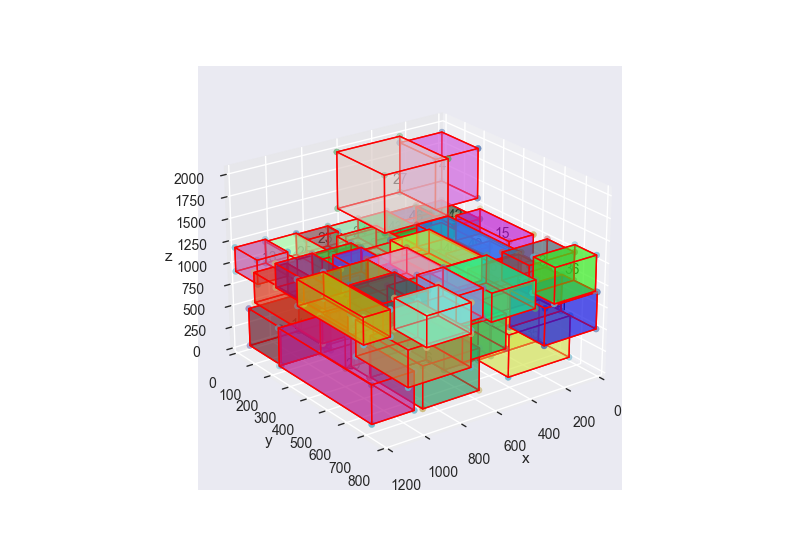

[<Axes3DSubplot:xlabel='x', ylabel='y'>]

<IPython.core.display.Javascript object>

In [31]:
cg_bin_pool.get_original_bin_pool().plot()

<IPython.core.display.Javascript object>


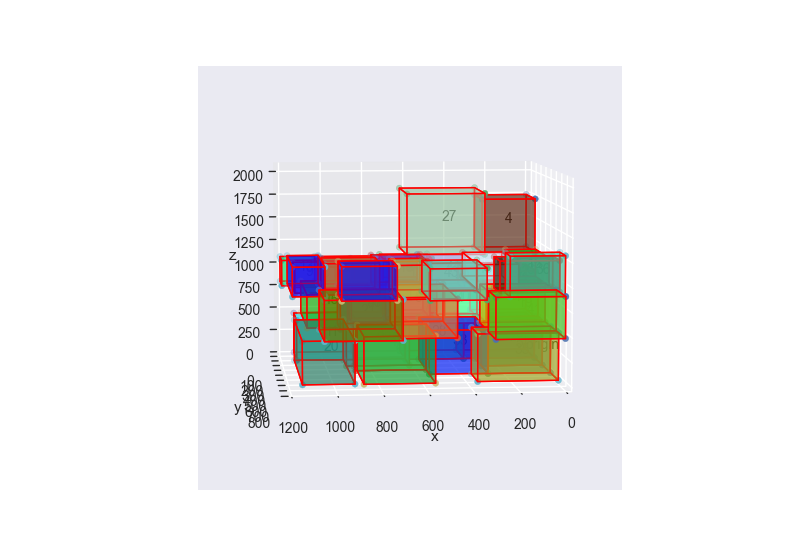

[<Axes3DSubplot:xlabel='x', ylabel='y'>]

<IPython.core.display.Javascript object>

In [32]:
cg_bin_pool.plot()

In [ ]:
diff = (
    cg_bin_pool.get_original_layer_pool()
    .to_dataframe()
    .merge(
        mr_bin_pool.get_original_layer_pool().to_dataframe(),
        on="item",
        suffixes=("_cg", "_mr"),
    )
)
diff["xd"] = diff["x_cg"] - diff["x_mr"]
diff["yd"] = diff["y_cg"] - diff["y_mr"]
diff["zd"] = diff["z_cg"] - diff["z_mr"]
diff[["item", "xd", "yd", "zd"]]

## Comparison

In [55]:
print("\tCG")
print("Bin Heights:", cg_bin_pool.get_heights())
print()
print("Bin Densities:", cg_bin_pool.get_bin_densities())
print()
print("Layer Densities:", cg_bin_pool.get_layer_densities(two_dims=False))
print()
print("\tMR")
print("Bin Heights:", mr_bin_pool.get_heights())
print()
print("Bin Densities:", mr_bin_pool.get_bin_densities())
print()
print("Layer Densities:", mr_layer_pool.get_densities(two_dims=False))

	CG
Bin Heights: [1543]

Bin Densities: [0.45399603862530413]

Layer Densities: [[0.7665031465665977, 0.7084644678776683, 0.4206487241972477]]

	MR
Bin Heights: [1715]

Bin Densities: [0.45399603862530413]

Layer Densities: [0.5825106731014271, 0.5504133117816092, 0.48390885308385306]


<IPython.core.display.Javascript object>